# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

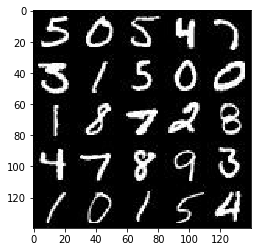

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

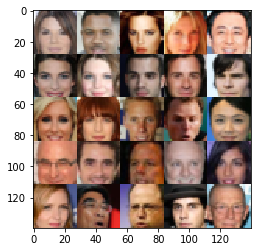

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        # Flatten image
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshpae it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x64
        
        x4 = tf.layers.conv2d_transpose(x3, 32, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 32x32x32
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 3, strides=1, padding='same')
        # 28x28x3
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # Smoothing factor
    smooth = 0.9
    
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * smooth))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # Inputs
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    # Loss
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    # Optimization
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Scaling batch_images by 2
                batch_images *= 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1004... Generator Loss: 1.8921
Epoch 1/2... Discriminator Loss: 1.6455... Generator Loss: 2.6907
Epoch 1/2... Discriminator Loss: 1.6594... Generator Loss: 2.2833
Epoch 1/2... Discriminator Loss: 0.8431... Generator Loss: 1.6083
Epoch 1/2... Discriminator Loss: 1.1861... Generator Loss: 2.5332
Epoch 1/2... Discriminator Loss: 1.3491... Generator Loss: 0.9118
Epoch 1/2... Discriminator Loss: 1.3917... Generator Loss: 0.5279
Epoch 1/2... Discriminator Loss: 1.3043... Generator Loss: 0.5854
Epoch 1/2... Discriminator Loss: 1.4344... Generator Loss: 0.5067
Epoch 1/2... Discriminator Loss: 1.8634... Generator Loss: 0.3050


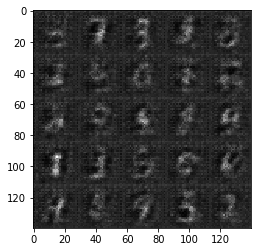

Epoch 1/2... Discriminator Loss: 1.4178... Generator Loss: 0.5453
Epoch 1/2... Discriminator Loss: 1.2599... Generator Loss: 0.6276
Epoch 1/2... Discriminator Loss: 1.4657... Generator Loss: 0.4439
Epoch 1/2... Discriminator Loss: 1.3887... Generator Loss: 0.5159
Epoch 1/2... Discriminator Loss: 1.1668... Generator Loss: 0.7208
Epoch 1/2... Discriminator Loss: 1.3568... Generator Loss: 0.5415
Epoch 1/2... Discriminator Loss: 1.2646... Generator Loss: 0.5769
Epoch 1/2... Discriminator Loss: 1.3579... Generator Loss: 0.5452
Epoch 1/2... Discriminator Loss: 1.3843... Generator Loss: 0.4801
Epoch 1/2... Discriminator Loss: 1.2597... Generator Loss: 0.5688


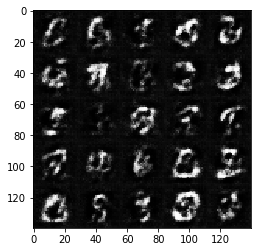

Epoch 1/2... Discriminator Loss: 1.2937... Generator Loss: 0.5523
Epoch 1/2... Discriminator Loss: 0.9761... Generator Loss: 1.0316
Epoch 1/2... Discriminator Loss: 1.5609... Generator Loss: 2.6389
Epoch 1/2... Discriminator Loss: 1.0570... Generator Loss: 1.6355
Epoch 1/2... Discriminator Loss: 1.1904... Generator Loss: 1.8039
Epoch 1/2... Discriminator Loss: 1.1284... Generator Loss: 1.7258
Epoch 1/2... Discriminator Loss: 0.9637... Generator Loss: 1.6488
Epoch 1/2... Discriminator Loss: 1.0984... Generator Loss: 1.7728
Epoch 1/2... Discriminator Loss: 1.0895... Generator Loss: 1.9402
Epoch 1/2... Discriminator Loss: 0.8687... Generator Loss: 1.3615


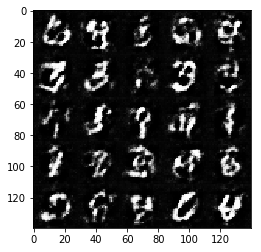

Epoch 1/2... Discriminator Loss: 1.2961... Generator Loss: 2.2429
Epoch 1/2... Discriminator Loss: 0.9945... Generator Loss: 1.2634
Epoch 1/2... Discriminator Loss: 1.3869... Generator Loss: 0.4929
Epoch 1/2... Discriminator Loss: 1.7699... Generator Loss: 0.3077
Epoch 1/2... Discriminator Loss: 1.2630... Generator Loss: 0.5675
Epoch 1/2... Discriminator Loss: 1.5274... Generator Loss: 0.3905
Epoch 1/2... Discriminator Loss: 1.5029... Generator Loss: 0.4373
Epoch 1/2... Discriminator Loss: 1.4186... Generator Loss: 0.4755
Epoch 1/2... Discriminator Loss: 1.3968... Generator Loss: 0.4884
Epoch 1/2... Discriminator Loss: 1.1927... Generator Loss: 0.6624


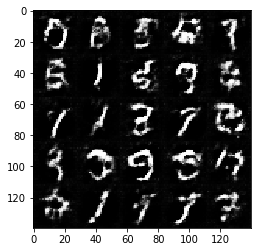

Epoch 1/2... Discriminator Loss: 1.2193... Generator Loss: 1.4655
Epoch 1/2... Discriminator Loss: 1.0738... Generator Loss: 1.1345
Epoch 1/2... Discriminator Loss: 1.2916... Generator Loss: 2.0049
Epoch 1/2... Discriminator Loss: 1.3701... Generator Loss: 1.7378
Epoch 1/2... Discriminator Loss: 1.0873... Generator Loss: 1.4694
Epoch 1/2... Discriminator Loss: 1.1396... Generator Loss: 1.0982
Epoch 1/2... Discriminator Loss: 1.1304... Generator Loss: 1.0676
Epoch 1/2... Discriminator Loss: 1.2515... Generator Loss: 1.8849
Epoch 1/2... Discriminator Loss: 1.0677... Generator Loss: 1.2822
Epoch 1/2... Discriminator Loss: 1.1382... Generator Loss: 1.1298


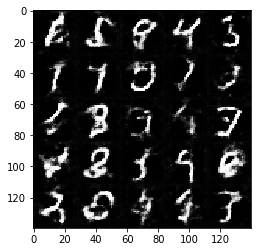

Epoch 1/2... Discriminator Loss: 1.1479... Generator Loss: 1.4696
Epoch 1/2... Discriminator Loss: 1.2875... Generator Loss: 0.5563
Epoch 1/2... Discriminator Loss: 1.4843... Generator Loss: 0.4388
Epoch 1/2... Discriminator Loss: 1.1680... Generator Loss: 1.2436
Epoch 1/2... Discriminator Loss: 1.0973... Generator Loss: 1.0762
Epoch 1/2... Discriminator Loss: 1.0858... Generator Loss: 0.7945
Epoch 1/2... Discriminator Loss: 1.3907... Generator Loss: 0.5192
Epoch 1/2... Discriminator Loss: 1.3231... Generator Loss: 0.5486
Epoch 1/2... Discriminator Loss: 1.1423... Generator Loss: 1.0352
Epoch 1/2... Discriminator Loss: 1.2352... Generator Loss: 1.5463


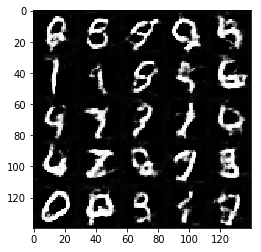

Epoch 1/2... Discriminator Loss: 0.9900... Generator Loss: 1.0836
Epoch 1/2... Discriminator Loss: 1.1527... Generator Loss: 0.7147
Epoch 1/2... Discriminator Loss: 1.3616... Generator Loss: 0.5103
Epoch 1/2... Discriminator Loss: 1.0215... Generator Loss: 0.8734
Epoch 1/2... Discriminator Loss: 1.0894... Generator Loss: 0.7784
Epoch 1/2... Discriminator Loss: 1.4675... Generator Loss: 0.4533
Epoch 1/2... Discriminator Loss: 1.2800... Generator Loss: 0.6043
Epoch 1/2... Discriminator Loss: 1.2555... Generator Loss: 0.6113
Epoch 1/2... Discriminator Loss: 1.3324... Generator Loss: 1.7794
Epoch 1/2... Discriminator Loss: 1.0952... Generator Loss: 0.9481


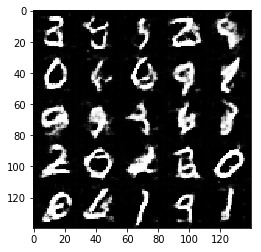

Epoch 1/2... Discriminator Loss: 1.0478... Generator Loss: 0.8436
Epoch 1/2... Discriminator Loss: 1.1683... Generator Loss: 1.5560
Epoch 1/2... Discriminator Loss: 0.9534... Generator Loss: 1.0837
Epoch 1/2... Discriminator Loss: 1.1018... Generator Loss: 1.4831
Epoch 1/2... Discriminator Loss: 1.2868... Generator Loss: 1.9689
Epoch 1/2... Discriminator Loss: 1.2462... Generator Loss: 1.8619
Epoch 1/2... Discriminator Loss: 1.0354... Generator Loss: 1.1549
Epoch 1/2... Discriminator Loss: 1.1671... Generator Loss: 0.7272
Epoch 1/2... Discriminator Loss: 1.6366... Generator Loss: 2.4917
Epoch 1/2... Discriminator Loss: 1.1543... Generator Loss: 0.7263


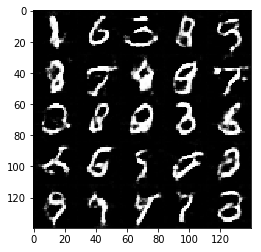

Epoch 1/2... Discriminator Loss: 1.0047... Generator Loss: 1.2226
Epoch 1/2... Discriminator Loss: 1.1973... Generator Loss: 0.6447
Epoch 1/2... Discriminator Loss: 1.0308... Generator Loss: 0.9622
Epoch 1/2... Discriminator Loss: 1.0366... Generator Loss: 1.1558
Epoch 1/2... Discriminator Loss: 1.0272... Generator Loss: 0.9906
Epoch 1/2... Discriminator Loss: 1.1550... Generator Loss: 1.5909
Epoch 1/2... Discriminator Loss: 1.0924... Generator Loss: 0.7557
Epoch 1/2... Discriminator Loss: 1.4991... Generator Loss: 2.4985
Epoch 1/2... Discriminator Loss: 1.1148... Generator Loss: 0.8481
Epoch 1/2... Discriminator Loss: 1.0639... Generator Loss: 0.8175


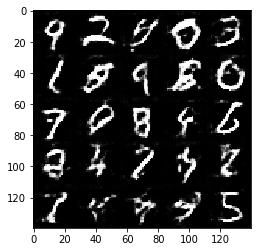

Epoch 1/2... Discriminator Loss: 1.2122... Generator Loss: 0.6186
Epoch 1/2... Discriminator Loss: 1.1310... Generator Loss: 0.7929
Epoch 1/2... Discriminator Loss: 2.2449... Generator Loss: 0.2007
Epoch 2/2... Discriminator Loss: 1.0603... Generator Loss: 1.0377
Epoch 2/2... Discriminator Loss: 0.9980... Generator Loss: 1.1595
Epoch 2/2... Discriminator Loss: 0.9643... Generator Loss: 1.3486
Epoch 2/2... Discriminator Loss: 0.9901... Generator Loss: 1.0578
Epoch 2/2... Discriminator Loss: 1.3581... Generator Loss: 0.5743
Epoch 2/2... Discriminator Loss: 1.0213... Generator Loss: 0.9958
Epoch 2/2... Discriminator Loss: 1.1687... Generator Loss: 0.6981


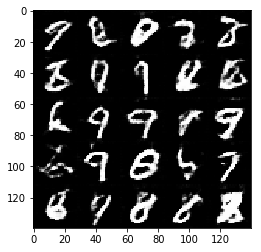

Epoch 2/2... Discriminator Loss: 1.4101... Generator Loss: 0.5290
Epoch 2/2... Discriminator Loss: 1.0238... Generator Loss: 1.0321
Epoch 2/2... Discriminator Loss: 1.0819... Generator Loss: 0.7717
Epoch 2/2... Discriminator Loss: 1.2137... Generator Loss: 0.6275
Epoch 2/2... Discriminator Loss: 1.0073... Generator Loss: 0.9354
Epoch 2/2... Discriminator Loss: 2.5530... Generator Loss: 3.3909
Epoch 2/2... Discriminator Loss: 1.1821... Generator Loss: 0.7415
Epoch 2/2... Discriminator Loss: 0.9947... Generator Loss: 1.0217
Epoch 2/2... Discriminator Loss: 0.9722... Generator Loss: 0.9062
Epoch 2/2... Discriminator Loss: 1.1925... Generator Loss: 1.5260


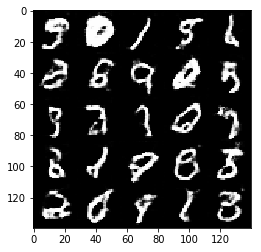

Epoch 2/2... Discriminator Loss: 0.9930... Generator Loss: 1.2301
Epoch 2/2... Discriminator Loss: 0.9160... Generator Loss: 1.0919
Epoch 2/2... Discriminator Loss: 1.0996... Generator Loss: 0.7612
Epoch 2/2... Discriminator Loss: 0.9995... Generator Loss: 0.8775
Epoch 2/2... Discriminator Loss: 1.9500... Generator Loss: 0.2581
Epoch 2/2... Discriminator Loss: 1.1238... Generator Loss: 0.7391
Epoch 2/2... Discriminator Loss: 1.6248... Generator Loss: 0.3696
Epoch 2/2... Discriminator Loss: 0.9665... Generator Loss: 1.0173
Epoch 2/2... Discriminator Loss: 1.0788... Generator Loss: 1.0738
Epoch 2/2... Discriminator Loss: 2.3486... Generator Loss: 0.1884


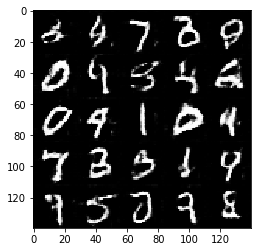

Epoch 2/2... Discriminator Loss: 0.8682... Generator Loss: 1.2332
Epoch 2/2... Discriminator Loss: 1.0549... Generator Loss: 0.8218
Epoch 2/2... Discriminator Loss: 1.5991... Generator Loss: 0.3962
Epoch 2/2... Discriminator Loss: 1.0491... Generator Loss: 0.8081
Epoch 2/2... Discriminator Loss: 1.0338... Generator Loss: 0.7933
Epoch 2/2... Discriminator Loss: 0.9217... Generator Loss: 1.6323
Epoch 2/2... Discriminator Loss: 1.0912... Generator Loss: 1.2951
Epoch 2/2... Discriminator Loss: 1.0130... Generator Loss: 1.0283
Epoch 2/2... Discriminator Loss: 2.0375... Generator Loss: 0.2890
Epoch 2/2... Discriminator Loss: 1.1153... Generator Loss: 0.7960


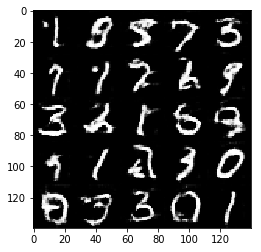

Epoch 2/2... Discriminator Loss: 1.2427... Generator Loss: 0.6451
Epoch 2/2... Discriminator Loss: 0.9317... Generator Loss: 0.9815
Epoch 2/2... Discriminator Loss: 0.9492... Generator Loss: 1.3697
Epoch 2/2... Discriminator Loss: 1.1838... Generator Loss: 0.6910
Epoch 2/2... Discriminator Loss: 0.9636... Generator Loss: 0.9789
Epoch 2/2... Discriminator Loss: 0.9409... Generator Loss: 1.3441
Epoch 2/2... Discriminator Loss: 1.1739... Generator Loss: 1.2262
Epoch 2/2... Discriminator Loss: 0.8937... Generator Loss: 1.0194
Epoch 2/2... Discriminator Loss: 1.8287... Generator Loss: 0.3121
Epoch 2/2... Discriminator Loss: 1.2513... Generator Loss: 0.5822


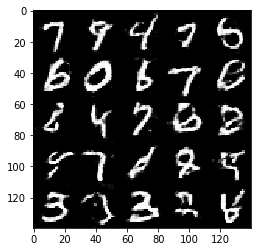

Epoch 2/2... Discriminator Loss: 1.0412... Generator Loss: 0.8031
Epoch 2/2... Discriminator Loss: 1.0555... Generator Loss: 1.0749
Epoch 2/2... Discriminator Loss: 1.0949... Generator Loss: 0.9655
Epoch 2/2... Discriminator Loss: 0.9960... Generator Loss: 1.0663
Epoch 2/2... Discriminator Loss: 1.1058... Generator Loss: 1.2691
Epoch 2/2... Discriminator Loss: 1.1453... Generator Loss: 0.7302
Epoch 2/2... Discriminator Loss: 1.0836... Generator Loss: 0.8413
Epoch 2/2... Discriminator Loss: 1.0334... Generator Loss: 0.8995
Epoch 2/2... Discriminator Loss: 1.0689... Generator Loss: 0.7845
Epoch 2/2... Discriminator Loss: 1.5801... Generator Loss: 2.0889


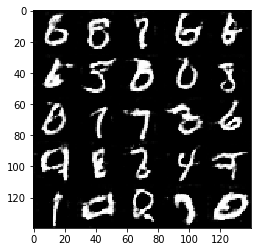

Epoch 2/2... Discriminator Loss: 1.1104... Generator Loss: 1.6056
Epoch 2/2... Discriminator Loss: 1.2281... Generator Loss: 0.5963
Epoch 2/2... Discriminator Loss: 1.1989... Generator Loss: 0.6368
Epoch 2/2... Discriminator Loss: 1.1488... Generator Loss: 0.6778
Epoch 2/2... Discriminator Loss: 1.2461... Generator Loss: 0.5787
Epoch 2/2... Discriminator Loss: 1.3027... Generator Loss: 2.0114
Epoch 2/2... Discriminator Loss: 1.0520... Generator Loss: 1.0441
Epoch 2/2... Discriminator Loss: 0.9275... Generator Loss: 1.3634
Epoch 2/2... Discriminator Loss: 1.3028... Generator Loss: 2.2915
Epoch 2/2... Discriminator Loss: 1.0601... Generator Loss: 0.8763


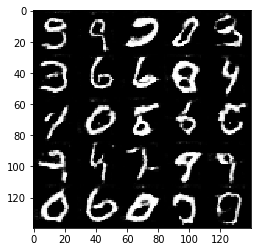

Epoch 2/2... Discriminator Loss: 1.0294... Generator Loss: 0.8858
Epoch 2/2... Discriminator Loss: 1.2414... Generator Loss: 0.6184
Epoch 2/2... Discriminator Loss: 0.9013... Generator Loss: 1.0573
Epoch 2/2... Discriminator Loss: 1.8300... Generator Loss: 3.3603
Epoch 2/2... Discriminator Loss: 1.0529... Generator Loss: 1.2897
Epoch 2/2... Discriminator Loss: 1.2732... Generator Loss: 0.5953
Epoch 2/2... Discriminator Loss: 1.7839... Generator Loss: 0.3525
Epoch 2/2... Discriminator Loss: 0.8517... Generator Loss: 1.4343
Epoch 2/2... Discriminator Loss: 1.1966... Generator Loss: 0.6713
Epoch 2/2... Discriminator Loss: 0.9332... Generator Loss: 0.9539


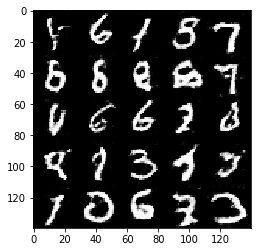

Epoch 2/2... Discriminator Loss: 1.4691... Generator Loss: 0.5009
Epoch 2/2... Discriminator Loss: 0.9657... Generator Loss: 1.4629
Epoch 2/2... Discriminator Loss: 1.3854... Generator Loss: 0.5912
Epoch 2/2... Discriminator Loss: 1.0661... Generator Loss: 0.8996
Epoch 2/2... Discriminator Loss: 0.9723... Generator Loss: 1.1981
Epoch 2/2... Discriminator Loss: 1.0679... Generator Loss: 1.7528
Epoch 2/2... Discriminator Loss: 0.7962... Generator Loss: 1.4304
Epoch 2/2... Discriminator Loss: 2.1365... Generator Loss: 0.2178
Epoch 2/2... Discriminator Loss: 0.9610... Generator Loss: 1.0062
Epoch 2/2... Discriminator Loss: 1.3707... Generator Loss: 2.6688


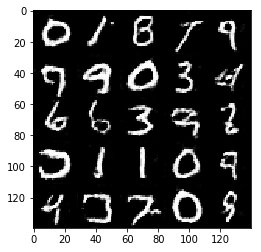

Epoch 2/2... Discriminator Loss: 2.1994... Generator Loss: 0.2450
Epoch 2/2... Discriminator Loss: 0.8508... Generator Loss: 1.2009
Epoch 2/2... Discriminator Loss: 0.9180... Generator Loss: 0.9543
Epoch 2/2... Discriminator Loss: 0.8626... Generator Loss: 1.6366
Epoch 2/2... Discriminator Loss: 0.9835... Generator Loss: 1.0214
Epoch 2/2... Discriminator Loss: 1.0332... Generator Loss: 1.6037
Epoch 2/2... Discriminator Loss: 1.3061... Generator Loss: 1.6574


In [14]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7827... Generator Loss: 2.1904
Epoch 1/1... Discriminator Loss: 2.5518... Generator Loss: 0.1620
Epoch 1/1... Discriminator Loss: 3.6254... Generator Loss: 0.0520
Epoch 1/1... Discriminator Loss: 2.0537... Generator Loss: 9.6781
Epoch 1/1... Discriminator Loss: 0.8129... Generator Loss: 2.1337
Epoch 1/1... Discriminator Loss: 2.1248... Generator Loss: 0.2302
Epoch 1/1... Discriminator Loss: 0.6048... Generator Loss: 2.3374
Epoch 1/1... Discriminator Loss: 0.5640... Generator Loss: 2.4496
Epoch 1/1... Discriminator Loss: 0.5220... Generator Loss: 2.1733
Epoch 1/1... Discriminator Loss: 0.5957... Generator Loss: 1.8329


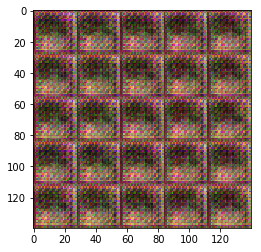

Epoch 1/1... Discriminator Loss: 0.6263... Generator Loss: 2.0196
Epoch 1/1... Discriminator Loss: 0.5561... Generator Loss: 2.0586
Epoch 1/1... Discriminator Loss: 0.5684... Generator Loss: 1.6684
Epoch 1/1... Discriminator Loss: 0.4494... Generator Loss: 4.8159
Epoch 1/1... Discriminator Loss: 0.4397... Generator Loss: 2.9996
Epoch 1/1... Discriminator Loss: 0.5944... Generator Loss: 1.6314
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.5169
Epoch 1/1... Discriminator Loss: 0.7914... Generator Loss: 1.4105
Epoch 1/1... Discriminator Loss: 1.0505... Generator Loss: 2.7783
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 4.5848


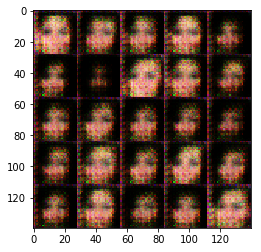

Epoch 1/1... Discriminator Loss: 0.8396... Generator Loss: 1.1964
Epoch 1/1... Discriminator Loss: 1.5854... Generator Loss: 0.4632
Epoch 1/1... Discriminator Loss: 0.9048... Generator Loss: 2.8389
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 0.6834
Epoch 1/1... Discriminator Loss: 0.8983... Generator Loss: 2.0686
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 4.0284
Epoch 1/1... Discriminator Loss: 0.9501... Generator Loss: 2.2967
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.5755
Epoch 1/1... Discriminator Loss: 0.9575... Generator Loss: 2.6755
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 0.7226


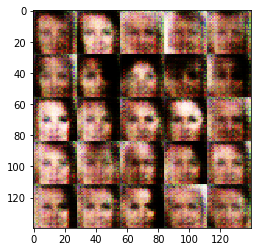

Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.6112... Generator Loss: 0.3909
Epoch 1/1... Discriminator Loss: 1.6170... Generator Loss: 0.4291
Epoch 1/1... Discriminator Loss: 0.7859... Generator Loss: 1.4233
Epoch 1/1... Discriminator Loss: 0.9422... Generator Loss: 2.3416
Epoch 1/1... Discriminator Loss: 0.9221... Generator Loss: 1.7975
Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 4.2626
Epoch 1/1... Discriminator Loss: 0.9917... Generator Loss: 0.9767
Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.8806... Generator Loss: 0.2935


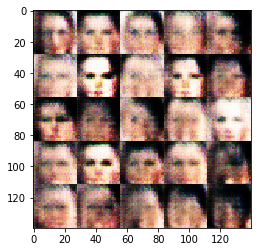

Epoch 1/1... Discriminator Loss: 1.0125... Generator Loss: 1.8989
Epoch 1/1... Discriminator Loss: 0.8999... Generator Loss: 1.0793
Epoch 1/1... Discriminator Loss: 0.9445... Generator Loss: 0.9191
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 2.1711... Generator Loss: 0.2039
Epoch 1/1... Discriminator Loss: 1.2437... Generator Loss: 0.5836
Epoch 1/1... Discriminator Loss: 1.4783... Generator Loss: 3.3857
Epoch 1/1... Discriminator Loss: 1.5789... Generator Loss: 0.4030
Epoch 1/1... Discriminator Loss: 1.0539... Generator Loss: 1.5570
Epoch 1/1... Discriminator Loss: 1.1515... Generator Loss: 1.5103


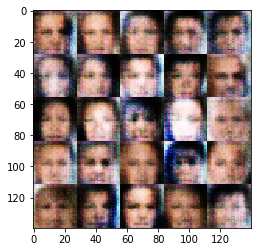

Epoch 1/1... Discriminator Loss: 0.9649... Generator Loss: 2.8437
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 2.4934
Epoch 1/1... Discriminator Loss: 1.0061... Generator Loss: 0.9554
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.5171
Epoch 1/1... Discriminator Loss: 1.0104... Generator Loss: 0.8702
Epoch 1/1... Discriminator Loss: 1.5224... Generator Loss: 0.4669
Epoch 1/1... Discriminator Loss: 1.6472... Generator Loss: 0.3772
Epoch 1/1... Discriminator Loss: 0.9039... Generator Loss: 1.2790
Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 0.9041
Epoch 1/1... Discriminator Loss: 1.5269... Generator Loss: 0.4621


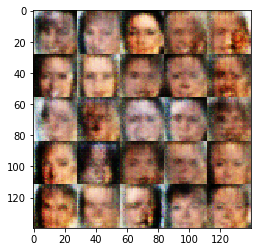

Epoch 1/1... Discriminator Loss: 1.9209... Generator Loss: 0.2645
Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.4761
Epoch 1/1... Discriminator Loss: 1.4880... Generator Loss: 0.4240
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 0.6712
Epoch 1/1... Discriminator Loss: 0.9325... Generator Loss: 1.1677
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.5662
Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.5396... Generator Loss: 0.3841
Epoch 1/1... Discriminator Loss: 1.6183... Generator Loss: 0.4024


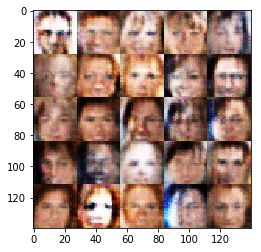

Epoch 1/1... Discriminator Loss: 0.9850... Generator Loss: 1.1083
Epoch 1/1... Discriminator Loss: 0.9405... Generator Loss: 1.1158
Epoch 1/1... Discriminator Loss: 1.7382... Generator Loss: 0.3183
Epoch 1/1... Discriminator Loss: 1.8088... Generator Loss: 0.2905
Epoch 1/1... Discriminator Loss: 1.1019... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.9894... Generator Loss: 0.2289
Epoch 1/1... Discriminator Loss: 1.7148... Generator Loss: 0.3365
Epoch 1/1... Discriminator Loss: 1.2216... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.5150
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 2.2715


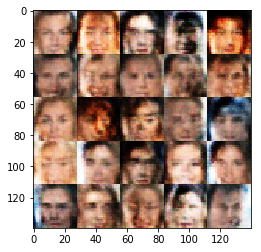

Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 1.8075
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.5270
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.4846
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.4509
Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.5019
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 1.5125
Epoch 1/1... Discriminator Loss: 0.9497... Generator Loss: 0.9652
Epoch 1/1... Discriminator Loss: 1.5509... Generator Loss: 0.4313


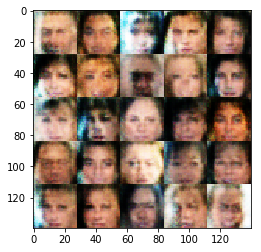

Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 0.9649... Generator Loss: 0.9222
Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.4451
Epoch 1/1... Discriminator Loss: 1.5684... Generator Loss: 0.3795
Epoch 1/1... Discriminator Loss: 1.2218... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 1.5731... Generator Loss: 0.3901
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.4778
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.4960
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 1.0873... Generator Loss: 0.7486


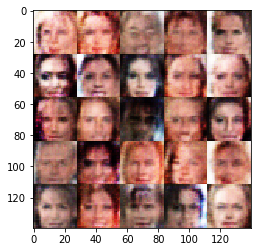

Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.0269... Generator Loss: 0.9624
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.5286
Epoch 1/1... Discriminator Loss: 0.9146... Generator Loss: 1.2978
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 1.5463
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.5289
Epoch 1/1... Discriminator Loss: 1.7096... Generator Loss: 0.3237
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.9292
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.4713
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.5003


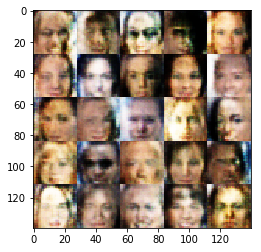

Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.0553... Generator Loss: 1.3781
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.5461
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.5229
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.5809
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.5466
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 0.8647
Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 0.6076


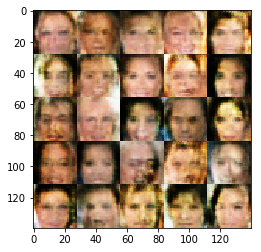

Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 1.2728
Epoch 1/1... Discriminator Loss: 1.0429... Generator Loss: 1.5612
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.4860
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.0666... Generator Loss: 0.9445
Epoch 1/1... Discriminator Loss: 0.9997... Generator Loss: 1.3132
Epoch 1/1... Discriminator Loss: 0.8815... Generator Loss: 1.3548
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 1.4762
Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 1.0418
Epoch 1/1... Discriminator Loss: 1.7841... Generator Loss: 0.2892


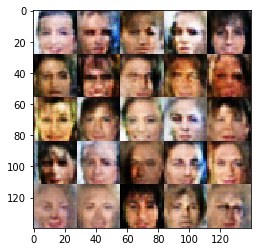

Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.4659
Epoch 1/1... Discriminator Loss: 1.0931... Generator Loss: 0.9860
Epoch 1/1... Discriminator Loss: 1.0695... Generator Loss: 1.0537
Epoch 1/1... Discriminator Loss: 1.2756... Generator Loss: 0.5625
Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 0.6103
Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 0.5886
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.1759... Generator Loss: 0.6655


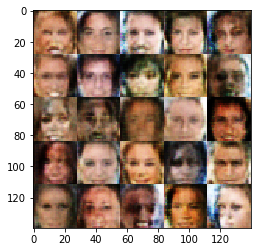

Epoch 1/1... Discriminator Loss: 1.0195... Generator Loss: 0.8863
Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 1.2497
Epoch 1/1... Discriminator Loss: 0.9464... Generator Loss: 1.2820
Epoch 1/1... Discriminator Loss: 1.0339... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.5722... Generator Loss: 0.3756
Epoch 1/1... Discriminator Loss: 0.8164... Generator Loss: 1.4645
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 0.9851... Generator Loss: 0.9640
Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.5723
Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 0.4250


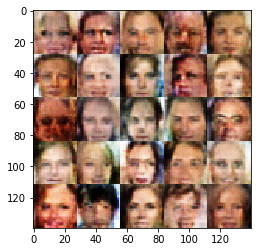

Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 1.5082
Epoch 1/1... Discriminator Loss: 0.9629... Generator Loss: 0.9279
Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.4571
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.4645
Epoch 1/1... Discriminator Loss: 1.0907... Generator Loss: 1.2583
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 0.5864
Epoch 1/1... Discriminator Loss: 1.0995... Generator Loss: 0.8806
Epoch 1/1... Discriminator Loss: 1.5768... Generator Loss: 2.0968
Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 1.7311


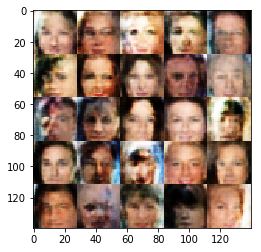

Epoch 1/1... Discriminator Loss: 1.6813... Generator Loss: 0.3471
Epoch 1/1... Discriminator Loss: 1.6546... Generator Loss: 0.3447
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.4303
Epoch 1/1... Discriminator Loss: 1.1696... Generator Loss: 0.9541
Epoch 1/1... Discriminator Loss: 0.7095... Generator Loss: 1.6321
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 0.8544
Epoch 1/1... Discriminator Loss: 0.9067... Generator Loss: 1.4067
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.5496
Epoch 1/1... Discriminator Loss: 0.9746... Generator Loss: 0.8609
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 1.2606


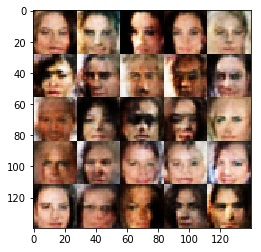

Epoch 1/1... Discriminator Loss: 1.0610... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.0773... Generator Loss: 1.0901
Epoch 1/1... Discriminator Loss: 1.5439... Generator Loss: 1.0654
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.0783... Generator Loss: 0.8747
Epoch 1/1... Discriminator Loss: 1.0930... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.5942
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.4517
Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 1.3559
Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 1.2158


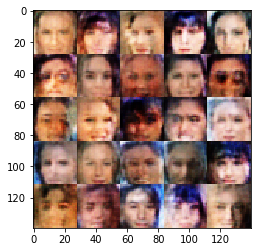

Epoch 1/1... Discriminator Loss: 0.9433... Generator Loss: 1.1780
Epoch 1/1... Discriminator Loss: 0.8576... Generator Loss: 1.0975
Epoch 1/1... Discriminator Loss: 1.0892... Generator Loss: 1.7998
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 1.4620
Epoch 1/1... Discriminator Loss: 0.9445... Generator Loss: 1.1445
Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 0.5945
Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 1.1537
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.4758
Epoch 1/1... Discriminator Loss: 1.0526... Generator Loss: 1.2801


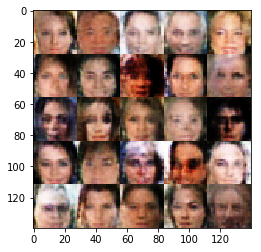

Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 1.3455
Epoch 1/1... Discriminator Loss: 1.9465... Generator Loss: 0.2659
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 0.9454
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.4873
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.4996
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.5760
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 1.5454
Epoch 1/1... Discriminator Loss: 0.9209... Generator Loss: 1.3293
Epoch 1/1... Discriminator Loss: 2.2194... Generator Loss: 0.1852
Epoch 1/1... Discriminator Loss: 1.0413... Generator Loss: 1.1073


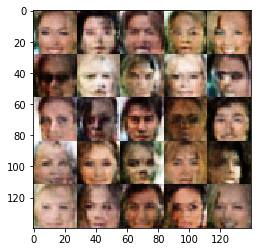

Epoch 1/1... Discriminator Loss: 1.0495... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 0.8610
Epoch 1/1... Discriminator Loss: 1.6895... Generator Loss: 0.3323
Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 1.2825
Epoch 1/1... Discriminator Loss: 1.1637... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 0.9927... Generator Loss: 1.4240
Epoch 1/1... Discriminator Loss: 1.5463... Generator Loss: 0.3932
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 0.6095
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 0.6485


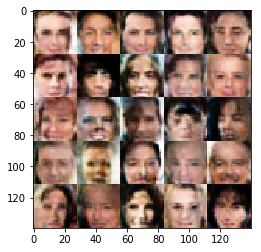

Epoch 1/1... Discriminator Loss: 1.5279... Generator Loss: 1.7930
Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.6135... Generator Loss: 0.3682
Epoch 1/1... Discriminator Loss: 1.0202... Generator Loss: 0.9376
Epoch 1/1... Discriminator Loss: 0.9798... Generator Loss: 1.1822
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.4823
Epoch 1/1... Discriminator Loss: 1.2973... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 1.1748
Epoch 1/1... Discriminator Loss: 0.9557... Generator Loss: 1.1269
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.5762


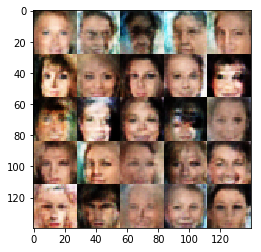

Epoch 1/1... Discriminator Loss: 1.5520... Generator Loss: 0.3991
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.0370... Generator Loss: 1.1493
Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.1730... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 1.5812
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.4993
Epoch 1/1... Discriminator Loss: 1.1852... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 1.1542... Generator Loss: 0.8092


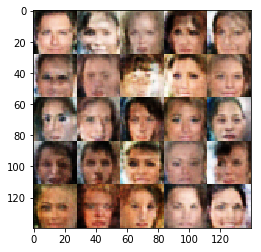

Epoch 1/1... Discriminator Loss: 0.9806... Generator Loss: 1.6595
Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 1.0101
Epoch 1/1... Discriminator Loss: 0.9943... Generator Loss: 1.3980
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.6583
Epoch 1/1... Discriminator Loss: 1.5664... Generator Loss: 0.3951
Epoch 1/1... Discriminator Loss: 1.0601... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 1.0592... Generator Loss: 1.2022
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 1.4496
Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.1767... Generator Loss: 0.6344


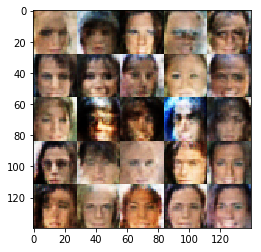

Epoch 1/1... Discriminator Loss: 1.5137... Generator Loss: 0.3961
Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.4390
Epoch 1/1... Discriminator Loss: 0.9926... Generator Loss: 0.8937
Epoch 1/1... Discriminator Loss: 1.6745... Generator Loss: 0.3512
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.4850
Epoch 1/1... Discriminator Loss: 1.0750... Generator Loss: 1.6155
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 1.1928
Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 0.9719... Generator Loss: 0.9450
Epoch 1/1... Discriminator Loss: 0.6876... Generator Loss: 2.0348


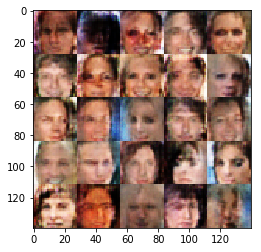

Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.5526
Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 1.7460
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.4600
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.5298
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.4996
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 1.2196
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.4551
Epoch 1/1... Discriminator Loss: 1.5861... Generator Loss: 0.4121
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.5195


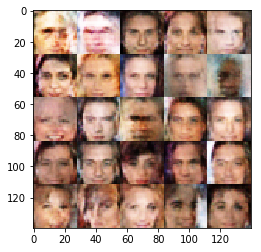

Epoch 1/1... Discriminator Loss: 0.9318... Generator Loss: 1.0774
Epoch 1/1... Discriminator Loss: 1.1150... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 0.9929... Generator Loss: 0.9557
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 0.5596
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.4913
Epoch 1/1... Discriminator Loss: 0.9798... Generator Loss: 1.0060
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.5106
Epoch 1/1... Discriminator Loss: 1.0240... Generator Loss: 0.8425


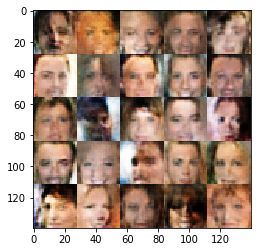

Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 0.5451
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 1.2104
Epoch 1/1... Discriminator Loss: 0.9377... Generator Loss: 1.0829
Epoch 1/1... Discriminator Loss: 1.0278... Generator Loss: 1.0186
Epoch 1/1... Discriminator Loss: 1.0003... Generator Loss: 1.4889
Epoch 1/1... Discriminator Loss: 1.0736... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.4939
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.4710
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.5227
Epoch 1/1... Discriminator Loss: 0.9635... Generator Loss: 0.9260


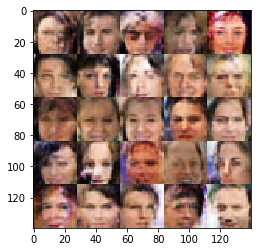

Epoch 1/1... Discriminator Loss: 1.0545... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.7335... Generator Loss: 0.3384
Epoch 1/1... Discriminator Loss: 0.9994... Generator Loss: 0.8614
Epoch 1/1... Discriminator Loss: 1.9857... Generator Loss: 0.2451
Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 0.6868
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.5677
Epoch 1/1... Discriminator Loss: 0.8852... Generator Loss: 1.2354
Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 0.9181
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.4641
Epoch 1/1... Discriminator Loss: 1.0191... Generator Loss: 0.9543


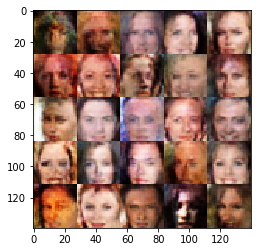

Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 0.9645
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.4467
Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 0.5443
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 1.6799
Epoch 1/1... Discriminator Loss: 0.7453... Generator Loss: 1.2686
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.4991
Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 2.0954
Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.4474
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.5699
Epoch 1/1... Discriminator Loss: 1.0266... Generator Loss: 0.8555


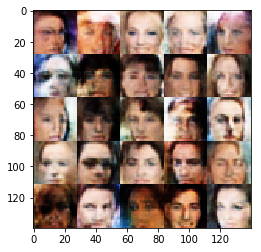

Epoch 1/1... Discriminator Loss: 0.9493... Generator Loss: 1.0619
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 1.7591
Epoch 1/1... Discriminator Loss: 2.0616... Generator Loss: 0.2359
Epoch 1/1... Discriminator Loss: 1.6293... Generator Loss: 0.3566
Epoch 1/1... Discriminator Loss: 1.1379... Generator Loss: 0.9978
Epoch 1/1... Discriminator Loss: 0.9762... Generator Loss: 1.1118
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.5607
Epoch 1/1... Discriminator Loss: 0.9494... Generator Loss: 1.0201
Epoch 1/1... Discriminator Loss: 2.0146... Generator Loss: 2.6106
Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 0.4864


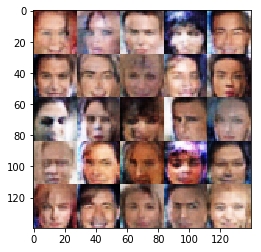

Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 1.4392
Epoch 1/1... Discriminator Loss: 1.6673... Generator Loss: 0.3515
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.0892... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 0.9027... Generator Loss: 1.4608
Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.4283
Epoch 1/1... Discriminator Loss: 1.5802... Generator Loss: 0.3710
Epoch 1/1... Discriminator Loss: 1.0207... Generator Loss: 1.0738
Epoch 1/1... Discriminator Loss: 0.9420... Generator Loss: 0.9635
Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 0.8143


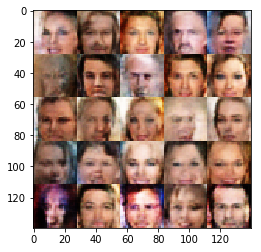

Epoch 1/1... Discriminator Loss: 1.2023... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 1.4956
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.4347
Epoch 1/1... Discriminator Loss: 1.0452... Generator Loss: 0.7177
Epoch 1/1... Discriminator Loss: 1.0613... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 0.5832
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.8883
Epoch 1/1... Discriminator Loss: 1.1630... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.4629
Epoch 1/1... Discriminator Loss: 2.0027... Generator Loss: 0.2274


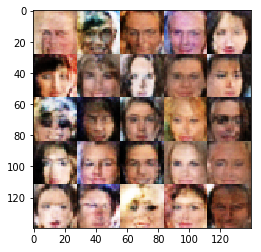

Epoch 1/1... Discriminator Loss: 2.1307... Generator Loss: 0.1959
Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 1.8785
Epoch 1/1... Discriminator Loss: 0.9446... Generator Loss: 1.0514
Epoch 1/1... Discriminator Loss: 1.5973... Generator Loss: 0.3803
Epoch 1/1... Discriminator Loss: 0.9873... Generator Loss: 1.3384
Epoch 1/1... Discriminator Loss: 1.0229... Generator Loss: 0.9164
Epoch 1/1... Discriminator Loss: 1.1211... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 0.8932... Generator Loss: 1.1250
Epoch 1/1... Discriminator Loss: 0.9381... Generator Loss: 1.1428
Epoch 1/1... Discriminator Loss: 1.4944... Generator Loss: 0.4037


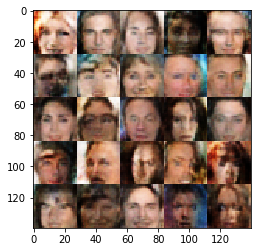

Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.5473
Epoch 1/1... Discriminator Loss: 1.0923... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.8861... Generator Loss: 0.3017
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.4404
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.4833
Epoch 1/1... Discriminator Loss: 1.0174... Generator Loss: 0.9391
Epoch 1/1... Discriminator Loss: 1.0490... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 2.2461... Generator Loss: 0.1892
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.5626


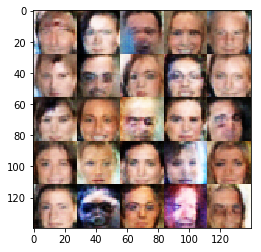

Epoch 1/1... Discriminator Loss: 1.0726... Generator Loss: 0.8548
Epoch 1/1... Discriminator Loss: 0.9239... Generator Loss: 1.4511
Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 0.6031
Epoch 1/1... Discriminator Loss: 1.5607... Generator Loss: 0.3851
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 1.4633
Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 1.0498
Epoch 1/1... Discriminator Loss: 1.1884... Generator Loss: 0.6708
Epoch 1/1... Discriminator Loss: 1.1433... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 1.9540


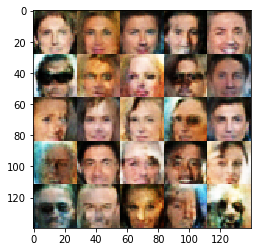

Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 1.5868
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 2.2234... Generator Loss: 0.1947
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.4928
Epoch 1/1... Discriminator Loss: 1.0413... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.5426... Generator Loss: 0.4015
Epoch 1/1... Discriminator Loss: 1.0004... Generator Loss: 1.0907
Epoch 1/1... Discriminator Loss: 1.2419... Generator Loss: 1.9645
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.4426
Epoch 1/1... Discriminator Loss: 1.0684... Generator Loss: 0.7994


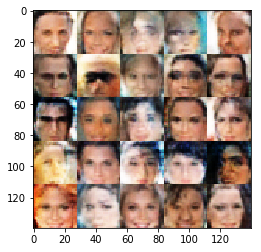

Epoch 1/1... Discriminator Loss: 2.0009... Generator Loss: 0.2525
Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 0.9403... Generator Loss: 1.2218
Epoch 1/1... Discriminator Loss: 1.1547... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 1.4493
Epoch 1/1... Discriminator Loss: 1.0657... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 2.5780
Epoch 1/1... Discriminator Loss: 1.5939... Generator Loss: 0.3765
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 0.5696


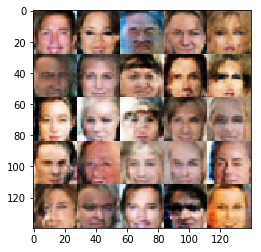

Epoch 1/1... Discriminator Loss: 0.9255... Generator Loss: 1.3347
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.5587
Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 0.9144... Generator Loss: 2.1622
Epoch 1/1... Discriminator Loss: 1.8534... Generator Loss: 1.8775
Epoch 1/1... Discriminator Loss: 1.1515... Generator Loss: 0.9082
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 1.7210
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 0.7465


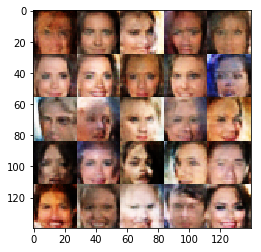

Epoch 1/1... Discriminator Loss: 1.2183... Generator Loss: 1.5855
Epoch 1/1... Discriminator Loss: 1.9182... Generator Loss: 0.2601
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 0.9017... Generator Loss: 1.2632
Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 0.9804
Epoch 1/1... Discriminator Loss: 1.1700... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 0.9781... Generator Loss: 0.8887
Epoch 1/1... Discriminator Loss: 0.9627... Generator Loss: 1.0162
Epoch 1/1... Discriminator Loss: 1.1313... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 0.8829... Generator Loss: 1.0648


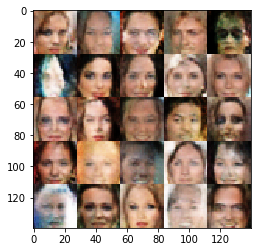

Epoch 1/1... Discriminator Loss: 1.5671... Generator Loss: 0.3939
Epoch 1/1... Discriminator Loss: 1.4544... Generator Loss: 0.4325
Epoch 1/1... Discriminator Loss: 0.8421... Generator Loss: 1.2695
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.4360
Epoch 1/1... Discriminator Loss: 1.0146... Generator Loss: 0.9829
Epoch 1/1... Discriminator Loss: 0.9677... Generator Loss: 1.0524
Epoch 1/1... Discriminator Loss: 1.0602... Generator Loss: 1.1384
Epoch 1/1... Discriminator Loss: 1.7390... Generator Loss: 0.3245
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.5609
Epoch 1/1... Discriminator Loss: 1.7703... Generator Loss: 2.6567


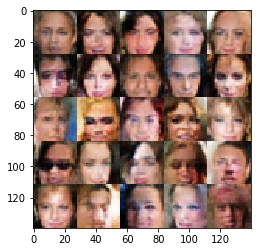

Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 0.8560
Epoch 1/1... Discriminator Loss: 0.9926... Generator Loss: 0.9520
Epoch 1/1... Discriminator Loss: 1.6312... Generator Loss: 2.4034
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.4967
Epoch 1/1... Discriminator Loss: 0.8912... Generator Loss: 1.0463
Epoch 1/1... Discriminator Loss: 0.9876... Generator Loss: 0.9164
Epoch 1/1... Discriminator Loss: 2.0846... Generator Loss: 0.2158
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 1.1033... Generator Loss: 0.6830


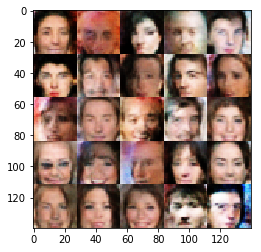

Epoch 1/1... Discriminator Loss: 1.6754... Generator Loss: 0.3329
Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 1.4572
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 1.0871
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 1.2265
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 0.5996
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.5321
Epoch 1/1... Discriminator Loss: 0.9320... Generator Loss: 1.1109
Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 1.0387
Epoch 1/1... Discriminator Loss: 0.8945... Generator Loss: 1.2768
Epoch 1/1... Discriminator Loss: 1.5290... Generator Loss: 0.4028


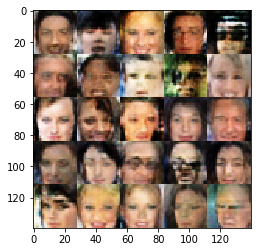

Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.4692
Epoch 1/1... Discriminator Loss: 0.9550... Generator Loss: 0.9779
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 0.6079
Epoch 1/1... Discriminator Loss: 1.5447... Generator Loss: 0.4215
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.5464
Epoch 1/1... Discriminator Loss: 0.9933... Generator Loss: 0.9231
Epoch 1/1... Discriminator Loss: 1.0555... Generator Loss: 0.8778
Epoch 1/1... Discriminator Loss: 1.5295... Generator Loss: 0.4000
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.8660... Generator Loss: 0.2910


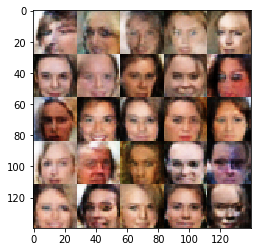

Epoch 1/1... Discriminator Loss: 1.0196... Generator Loss: 0.9305
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.5650
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 1.0121
Epoch 1/1... Discriminator Loss: 0.8611... Generator Loss: 1.4859
Epoch 1/1... Discriminator Loss: 1.1430... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.5555
Epoch 1/1... Discriminator Loss: 1.0458... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.4977
Epoch 1/1... Discriminator Loss: 0.8246... Generator Loss: 1.1621
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.6139


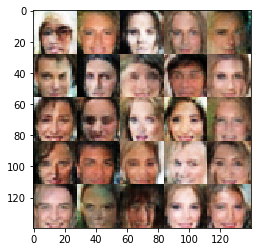

Epoch 1/1... Discriminator Loss: 1.7558... Generator Loss: 0.3048
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.5642
Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 0.5815
Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.0854... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.0643... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 1.3966
Epoch 1/1... Discriminator Loss: 0.9228... Generator Loss: 1.2021
Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 0.6792


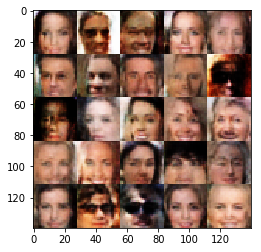

Epoch 1/1... Discriminator Loss: 1.7349... Generator Loss: 0.3027
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 1.7652... Generator Loss: 2.4375
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 0.8869
Epoch 1/1... Discriminator Loss: 0.9487... Generator Loss: 0.9800
Epoch 1/1... Discriminator Loss: 0.9636... Generator Loss: 1.6206
Epoch 1/1... Discriminator Loss: 0.9332... Generator Loss: 1.0988
Epoch 1/1... Discriminator Loss: 0.8267... Generator Loss: 1.9988
Epoch 1/1... Discriminator Loss: 1.0204... Generator Loss: 0.9752


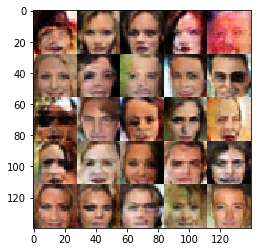

Epoch 1/1... Discriminator Loss: 1.0654... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.2328... Generator Loss: 0.5813
Epoch 1/1... Discriminator Loss: 1.5627... Generator Loss: 0.4014
Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.0195... Generator Loss: 1.0120
Epoch 1/1... Discriminator Loss: 0.9608... Generator Loss: 1.1479
Epoch 1/1... Discriminator Loss: 2.0565... Generator Loss: 0.2301
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.5163
Epoch 1/1... Discriminator Loss: 0.8610... Generator Loss: 1.3097
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.5186


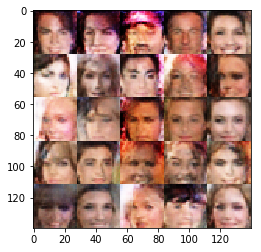

Epoch 1/1... Discriminator Loss: 1.0605... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.5998... Generator Loss: 0.3683
Epoch 1/1... Discriminator Loss: 0.9821... Generator Loss: 0.8916
Epoch 1/1... Discriminator Loss: 1.0626... Generator Loss: 0.8706
Epoch 1/1... Discriminator Loss: 0.8974... Generator Loss: 1.3719
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.4442
Epoch 1/1... Discriminator Loss: 0.7452... Generator Loss: 1.4751
Epoch 1/1... Discriminator Loss: 1.0852... Generator Loss: 1.2723
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 1.2434


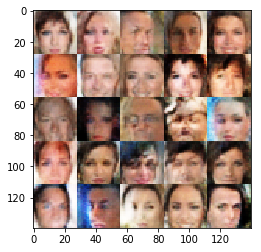

Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 1.2151
Epoch 1/1... Discriminator Loss: 0.9986... Generator Loss: 1.0935
Epoch 1/1... Discriminator Loss: 1.0359... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 0.9940... Generator Loss: 1.7642
Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 1.0200
Epoch 1/1... Discriminator Loss: 0.9181... Generator Loss: 1.1184
Epoch 1/1... Discriminator Loss: 0.8933... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 2.3728
Epoch 1/1... Discriminator Loss: 0.9391... Generator Loss: 0.8767


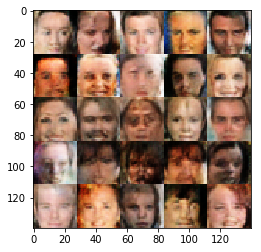

Epoch 1/1... Discriminator Loss: 0.8691... Generator Loss: 1.2678
Epoch 1/1... Discriminator Loss: 1.2359... Generator Loss: 0.6083
Epoch 1/1... Discriminator Loss: 0.8391... Generator Loss: 1.2621
Epoch 1/1... Discriminator Loss: 1.2091... Generator Loss: 1.6059
Epoch 1/1... Discriminator Loss: 1.0166... Generator Loss: 1.2697
Epoch 1/1... Discriminator Loss: 1.2837... Generator Loss: 0.5725
Epoch 1/1... Discriminator Loss: 2.2339... Generator Loss: 0.1949
Epoch 1/1... Discriminator Loss: 1.4663... Generator Loss: 0.4692
Epoch 1/1... Discriminator Loss: 0.9413... Generator Loss: 1.2099
Epoch 1/1... Discriminator Loss: 0.9398... Generator Loss: 0.9497


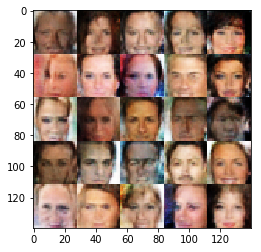

Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 1.7449
Epoch 1/1... Discriminator Loss: 1.0309... Generator Loss: 1.0544
Epoch 1/1... Discriminator Loss: 1.6514... Generator Loss: 0.3509
Epoch 1/1... Discriminator Loss: 1.5749... Generator Loss: 0.3784
Epoch 1/1... Discriminator Loss: 1.0634... Generator Loss: 1.7276
Epoch 1/1... Discriminator Loss: 1.5026... Generator Loss: 0.4393
Epoch 1/1... Discriminator Loss: 0.8924... Generator Loss: 1.1714
Epoch 1/1... Discriminator Loss: 1.0810... Generator Loss: 1.8118
Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 1.0954
Epoch 1/1... Discriminator Loss: 0.8054... Generator Loss: 1.1543


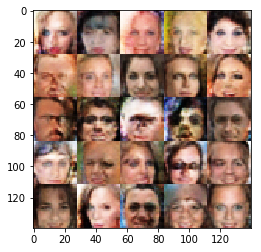

Epoch 1/1... Discriminator Loss: 1.8481... Generator Loss: 0.2756
Epoch 1/1... Discriminator Loss: 0.8012... Generator Loss: 1.2681
Epoch 1/1... Discriminator Loss: 1.0630... Generator Loss: 1.1617
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.5716
Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 0.9193
Epoch 1/1... Discriminator Loss: 0.9549... Generator Loss: 1.9063
Epoch 1/1... Discriminator Loss: 0.8616... Generator Loss: 1.1552
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 1.0038


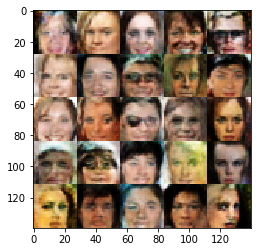

Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 0.8465
Epoch 1/1... Discriminator Loss: 0.8565... Generator Loss: 1.1502
Epoch 1/1... Discriminator Loss: 0.9404... Generator Loss: 1.0747
Epoch 1/1... Discriminator Loss: 1.8675... Generator Loss: 0.2810
Epoch 1/1... Discriminator Loss: 2.1657... Generator Loss: 0.1881
Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 0.9597
Epoch 1/1... Discriminator Loss: 1.9547... Generator Loss: 0.2433
Epoch 1/1... Discriminator Loss: 1.5714... Generator Loss: 0.3791
Epoch 1/1... Discriminator Loss: 0.9486... Generator Loss: 0.9818
Epoch 1/1... Discriminator Loss: 1.1083... Generator Loss: 0.7193


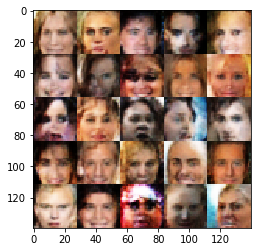

Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.5609
Epoch 1/1... Discriminator Loss: 0.9005... Generator Loss: 0.9824
Epoch 1/1... Discriminator Loss: 1.1139... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.4124
Epoch 1/1... Discriminator Loss: 0.9352... Generator Loss: 0.9664
Epoch 1/1... Discriminator Loss: 0.7104... Generator Loss: 1.5284
Epoch 1/1... Discriminator Loss: 0.9978... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.5556... Generator Loss: 0.4196
Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.4607


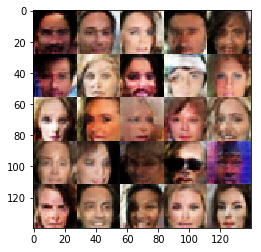

Epoch 1/1... Discriminator Loss: 0.9931... Generator Loss: 0.9561
Epoch 1/1... Discriminator Loss: 1.5760... Generator Loss: 0.3779
Epoch 1/1... Discriminator Loss: 1.6235... Generator Loss: 0.3855
Epoch 1/1... Discriminator Loss: 1.8692... Generator Loss: 0.2912
Epoch 1/1... Discriminator Loss: 0.7707... Generator Loss: 1.4790
Epoch 1/1... Discriminator Loss: 1.1463... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 0.8259... Generator Loss: 1.3019
Epoch 1/1... Discriminator Loss: 0.9161... Generator Loss: 1.1952
Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 1.0995
Epoch 1/1... Discriminator Loss: 0.9853... Generator Loss: 1.3017


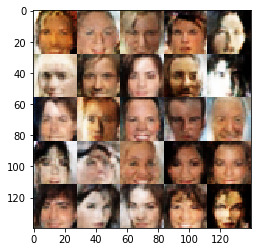

Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 0.6037
Epoch 1/1... Discriminator Loss: 0.9793... Generator Loss: 1.0422
Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 0.5915
Epoch 1/1... Discriminator Loss: 0.8330... Generator Loss: 1.0727
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 0.8923... Generator Loss: 1.3276
Epoch 1/1... Discriminator Loss: 0.9990... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.9420... Generator Loss: 0.2631
Epoch 1/1... Discriminator Loss: 0.8965... Generator Loss: 1.2880
Epoch 1/1... Discriminator Loss: 0.8510... Generator Loss: 1.1881


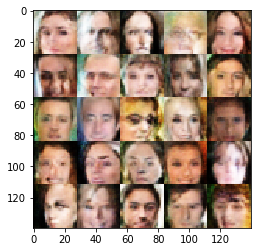

Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.9218... Generator Loss: 0.2641
Epoch 1/1... Discriminator Loss: 1.5876... Generator Loss: 0.3641
Epoch 1/1... Discriminator Loss: 2.1922... Generator Loss: 2.8100
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.4764
Epoch 1/1... Discriminator Loss: 1.1174... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 1.8449
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.5366
Epoch 1/1... Discriminator Loss: 0.9963... Generator Loss: 1.0581
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.4554


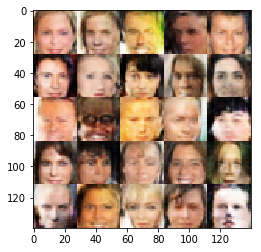

Epoch 1/1... Discriminator Loss: 1.5905... Generator Loss: 0.3954
Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.4826
Epoch 1/1... Discriminator Loss: 0.9499... Generator Loss: 2.0360
Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 0.6312
Epoch 1/1... Discriminator Loss: 1.0654... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 1.7481... Generator Loss: 0.3275
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 2.0717
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.5162


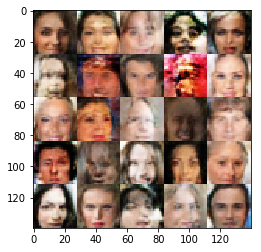

Epoch 1/1... Discriminator Loss: 1.0801... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.0348... Generator Loss: 1.6152
Epoch 1/1... Discriminator Loss: 1.9414... Generator Loss: 2.7617
Epoch 1/1... Discriminator Loss: 1.0325... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 0.5975
Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 1.2093
Epoch 1/1... Discriminator Loss: 1.0403... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 0.8510... Generator Loss: 1.0204
Epoch 1/1... Discriminator Loss: 0.8853... Generator Loss: 1.3517


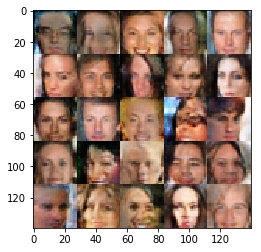

Epoch 1/1... Discriminator Loss: 1.5159... Generator Loss: 0.4047
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 1.8038
Epoch 1/1... Discriminator Loss: 1.0168... Generator Loss: 1.3106
Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 1.6805
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 0.9089... Generator Loss: 2.4494
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.9478... Generator Loss: 0.2870
Epoch 1/1... Discriminator Loss: 1.0162... Generator Loss: 0.8648
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 2.1208


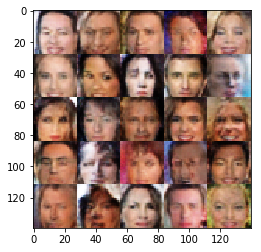

Epoch 1/1... Discriminator Loss: 1.0496... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.5088
Epoch 1/1... Discriminator Loss: 1.0280... Generator Loss: 0.9513
Epoch 1/1... Discriminator Loss: 1.5601... Generator Loss: 0.3853
Epoch 1/1... Discriminator Loss: 0.9695... Generator Loss: 0.8997
Epoch 1/1... Discriminator Loss: 0.9216... Generator Loss: 0.9589
Epoch 1/1... Discriminator Loss: 0.9375... Generator Loss: 1.1248
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.4644
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 1.5826
Epoch 1/1... Discriminator Loss: 1.1343... Generator Loss: 0.7337


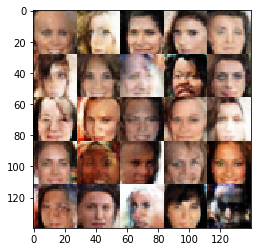

Epoch 1/1... Discriminator Loss: 1.7703... Generator Loss: 2.4533
Epoch 1/1... Discriminator Loss: 1.0863... Generator Loss: 0.7766
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.4195
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.5181
Epoch 1/1... Discriminator Loss: 1.0902... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.4585
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 2.1754
Epoch 1/1... Discriminator Loss: 1.0269... Generator Loss: 1.2002
Epoch 1/1... Discriminator Loss: 1.1059... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.5193... Generator Loss: 0.3972


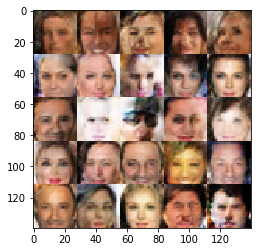

Epoch 1/1... Discriminator Loss: 1.8045... Generator Loss: 0.2874
Epoch 1/1... Discriminator Loss: 0.9928... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.1752... Generator Loss: 0.6498


In [20]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.